In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import json
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Data

- **installation_id** : Corresponde a cada instalação da aplicação (apesar de existir ruído por compartilhamento de aparelhos, cada installation_id se refere a uma criança.), nos dados de treino existem installation_id que nunca realizaram nenhum assessment, enquanto nos dados de teste fizeram ao menos uma tentativa de assessment.
- **accuracy_group** : Possui algumas possibilidades: 0,1,2,3. Os números dizem respeito ao número de tentativas realizadas para resolver assessment. Também é o target da competição.

### Train.csv e Test.csv

- **event_id**: Número gerado aleatoriamente para identificar o tipo de evento, ligado a event_id nos dados specs.csv
- **game_session**: Número gerado aleatoriamente para identificar agrupamento de eventos de um único jogo ou sessão de vídeo. (Comentário do Lucas: parece que existem n event_id para o mesmo game_session)
- **timestamp**: Datetime gerado pelo client
- **event_data**: JSON contendo os parâmetros do evento, os campos padrão são "event_count","event_code" e "game_time", outros campos são determinados pelo tipo de evento
- **event_code**: Identificador da 'classe' do evento, possui um por jogo mas pode acontecer de estar duplicado. (Por exemplo, o event_code 2000 sempre identificar o evento 'Start Game' para todos os jogos. Extraído de event_data.
- **installation_id** : Explicado la em cima.
- **event_count**: Contador incremental de eventos em uma mesma game_session (offset de 1), extraído de event_data.
- **game_time**: Tempo em milissegundos desde o início da game_session, extraído de event_data.
- **title**: Título do jogo ou vídeo.
- **world**: A qual "grupo" da aplicação o jogo ou vídeo percente. Ajuda a identificar o objetivo do curriculo educacional (?) (Comentário do Lucas: conferir na documentação original as possibilidades de valores.)

### specs.csv

- **event_id**: Identificador global do tipo de evento, ligado a tabela de eventos.
- **info**: Descrição do evento
- **args**: JSON contendo name (Nome do argumento), type (Tipo do argumento -> string, int, number, object, array), info (Descrição do argumento)

### Estrutura dos dados
<p style="text-align:center;"><img src = 'https://i.imgur.com/1dfbeIi.png' height="10%"></p>

### Objetivo
**Para cada installation_id nos dados de teste, preveja qual será o accuracy_score do ultimo assessment realizado por este id.**

## Input Data

In [2]:
DIR_PATH = ''
FILES_NAME = ['train.csv', 'specs.csv', 'sample_submission.csv', 'train_labels.csv', 'test.csv']

dataframes = dict()

for file in FILES_NAME:
    print(f'Reading {file}...')
    dataframes[file] = pd.read_csv(DIR_PATH + file)
    print(f'{file} possui {dataframes[file].shape[0]} linhas e {dataframes[file].shape[1]} colunas. \n')

Reading train.csv...
train.csv possui 11341042 linhas e 11 colunas. 

Reading specs.csv...
specs.csv possui 386 linhas e 3 colunas. 

Reading sample_submission.csv...
sample_submission.csv possui 1000 linhas e 2 colunas. 

Reading train_labels.csv...
train_labels.csv possui 17690 linhas e 7 colunas. 

Reading test.csv...
test.csv possui 1156414 linhas e 11 colunas. 



In [3]:
#Atribuindo dataframes as variáveis
train = dataframes['train.csv']
specs = dataframes['specs.csv']
sample = dataframes['sample_submission.csv']
labels = dataframes['train_labels.csv']
test = dataframes['test.csv']


#Datetimes
train['timestamp'] = pd.to_datetime(train.timestamp)
test['timestamp'] = pd.to_datetime(test.timestamp)

#Limpando memória
dataframes = dict()

## Primeiro contato
Usualmente não realizo essa parte antes do cleaning, mas é importante entender algumas coisas sobre os dados antes de continuarmos.
- Primeiro de tudo: Quantos usuários únicos (installation_id)/ sessões de jogo (game_session) existem em nosso treino, teste e labels?

In [4]:
print(f'Nos dados de treino existem {train.installation_id.nunique()} installation_id unicos e {train.game_session.nunique()} game_session unicas.\n')
print(f'Nos dados de teste existem {test.installation_id.nunique()} installation_id unicos e {test.game_session.nunique()} game_session unicas.\n')
print(f'Nos dados de label existem {labels.installation_id.nunique()} installation_id unicos e {labels.game_session.nunique()} game_session unicas.\n')

Nos dados de treino existem 17000 installation_id unicos e 303319 game_session unicas.

Nos dados de teste existem 1000 installation_id unicos e 28445 game_session unicas.

Nos dados de label existem 3614 installation_id unicos e 17690 game_session unicas.



- Quantas sessions são de fato "Assessments"?

In [5]:

print(f'Para treino {train.loc[train.type == "Assessment", "game_session"].nunique()} são sessões de Assessment\n')
print(f'Q: Nos dados de labels, todas as atividades possuem "Assessment" no título da atividade?')

i = 0
for title in labels.title:
    r = re.search('Assessment', title)
    if not r:
        i += 1
        
if i > 0:
    print('R: Existem atividades que não são Assessments')
else:
    print('R: Todas as atividades possuem "Assessment" no título da atividade.')

Para treino 21239 são sessões de Assessment

Q: Nos dados de labels, todas as atividades possuem "Assessment" no título da atividade?
R: Todas as atividades possuem "Assessment" no título da atividade.


## Crawler
Ok, não é exatamente um crawler. Mas o nome é legal então preferi chamar assim.

In [6]:
class Crawler:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.data = 0
        self.installation_id = 0
        
    def get_data(self, installation_id, verbose = 0):
        if verbose == 1:
            print(f'Adquirindo informação sobre id {installation_id}...')
            
        self.data = self.dataframe.loc[self.dataframe.installation_id == installation_id, :]
        self.installation_id = installation_id
        
        if verbose == 1:
            print(f'Feito!\n')
     
    
    def json_reader(self, session_id):
        response = {'tentativas': 0, 'acertos': 0, 'erros': 0}
        data_read = self.data.loc[self.data.game_session == session_id]
        for row in data_read.iterrows():
            if row[1]['title'] == 'Bird Measurer (Assessment)':
                if row[1]['event_code'] == 4110:
                    response['tentativas'] +=1
                    if json.loads(row[1]['event_data'])['correct'] == True:
                        response['acertos'] +=1
                    else:
                        response['erros'] +=1
            else:
                if row[1]['event_code'] == 4100:
                    response['tentativas'] += 1
                    if json.loads(row[1]['event_data'])['correct'] == True:
                        response['acertos'] += 1
                    else:
                        response['erros'] += 1
                
        return response
            
    def json_read_all(self):
        response = {'tentativas': 0, 'acertos': 0, 'erros': 0}
        
        for session_id in self.data.loc[self.data.type == 'Assessment'].game_session.unique():
            
            data_read = self.data.loc[self.data.game_session == session_id]
            for row in data_read.iterrows():
                if row[1]['title'] == 'Bird Measurer (Assessment)':
                    if row[1]['event_code'] == 4110:
                        response['tentativas'] +=1
                        if json.loads(row[1]['event_data'])['correct'] == True:
                            response['acertos'] +=1
                        else:
                            response['erros'] +=1
                else:
                    if row[1]['event_code'] == 4100:
                        response['tentativas'] += 1
                        if json.loads(row[1]['event_data'])['correct'] == True:
                            response['acertos'] += 1
                        else:
                            response['erros'] += 1

        return response
    
    
    def __gettime__(self):
        data = self.data.loc[(self.data.type == 'Assessment') & (self.data.event_code == 2010)]
        return data.game_time.sum() / 1000
    
    def summary(self):
        print(f'Summary para installation_id {self.installation_id}:')
        print('-' * 70)
        print(f'Número de sessões unicas: {self.data.game_session.nunique()}')
        print(f' - Clip:  {len(self.data.loc[self.data.type == "Clip"].groupby("game_session").count())}')
        print(f' - Game:  {len(self.data.loc[self.data.type == "Game"].groupby("game_session").count())}')
        print(f' - Activity:  {len(self.data.loc[self.data.type == "Activity"].groupby("game_session").count())}')
        print(f' - Assessment:  {len(self.data.loc[self.data.type == "Assessment"].groupby("game_session").count())}')
        print('-'*70)
        print(f'Numero de eventos médios por sessão: ')
        try:
            print(f' - Clip: {np.round(len(self.data.loc[self.data.type == "Clip"]) / len(self.data.loc[self.data.type == "Clip"].groupby("game_session").count()), 2)} ')
        except:
            print(' - Clip: 0')
        try:
            print(f' - Game: {np.round(len(self.data.loc[self.data.type == "Game"]) / len(self.data.loc[self.data.type == "Game"].groupby("game_session").count()), 2)} ')
        except:
            print(' - Game: 0')
        try:
            print(f' - Activity: {np.round(len(self.data.loc[self.data.type == "Activity"]) / len(self.data.loc[self.data.type == "Activity"].groupby("game_session").count()), 2)} ')
        except:
            print(' - Activity: 0')
        try:
            print(f' - Assessment: {np.round(len(self.data.loc[self.data.type == "Assessment"]) / len(self.data.loc[self.data.type == "Assessment"].groupby("game_session").count()), 2)} ')
        except:
            print(' - Assessment: 0')
        print('-'*70)
        print('Utilização:')
        print(f' - Início de utilização: {pd.to_datetime(self.data.timestamp.min())}')
        print(f' - Ultimo registro de utilização: {pd.to_datetime(self.data.timestamp.max())}')
        print(f' - Tempo decorrido: {pd.to_datetime(self.data.timestamp.max()) - pd.to_datetime(self.data.timestamp.min())}')
        print('-'*70)
        print('Assessments:')
        print(f' - Número total de assessments: {len(self.data.loc[self.data.type == "Assessment"].groupby("game_session").count())}')
        print(f' - Número total de tentativas: {self.json_read_all()["tentativas"]}')
        print(f' - Número total de acertos: {self.json_read_all()["acertos"]}')
        print(f' - Número total de erros: {self.json_read_all()["erros"]}')
        print(f' - Accuracy rate: {np.round(self.json_read_all()["acertos"] / self.json_read_all()["tentativas"], 4)}')
        
        
        
    def create_features(self):
        features = dict()
        features['sessao_total'] = self.data.game_session.nunique()
        features['sessao_clip'] = len(self.data.loc[self.data.type == "Clip"].groupby("game_session").count())
        features['sessao_game'] = len(self.data.loc[self.data.type == "Game"].groupby("game_session").count())
        features['sessao_activity'] = len(self.data.loc[self.data.type == "Activity"].groupby("game_session").count())
        features['sessao_assessment'] = len(self.data.loc[self.data.type == "Assessment"].groupby("game_session").count())
        features['total_acertos'] = self.json_read_all()['acertos']
        features['total_erros'] = self.json_read_all()['erros']
        features['total_tentativas'] = self.json_read_all()['tentativas']
        features['accuracy_rate_total'] = labels.loc[labels.installation_id == self.installation_id].accuracy.mean()
        features['tempo_de_instalacao'] = (pd.to_datetime(self.data.timestamp.max()) - pd.to_datetime(self.data.timestamp.min())).total_seconds()
        features['tempo_total_assessment'] = self.__gettime__()
        
        return features

In [7]:
crawler = Crawler(train)
crawler.get_data('0006a69f', verbose = 1)
crawler.summary()

Adquirindo informação sobre id 0006a69f...
Feito!

Summary para installation_id 0006a69f:
----------------------------------------------------------------------
Número de sessões unicas: 80
 - Clip:  37
 - Game:  20
 - Activity:  17
 - Assessment:  6
----------------------------------------------------------------------
Numero de eventos médios por sessão: 
 - Clip: 1.0 
 - Game: 86.6 
 - Activity: 104.18 
 - Assessment: 43.5 
----------------------------------------------------------------------
Utilização:
 - Início de utilização: 2019-08-06 04:57:18.904000+00:00
 - Ultimo registro de utilização: 2019-08-29 16:39:12.615000+00:00
 - Tempo decorrido: 23 days 11:41:53.711000
----------------------------------------------------------------------
Assessments:
 - Número total de assessments: 6
 - Número total de tentativas: 16
 - Número total de acertos: 4
 - Número total de erros: 12
 - Accuracy rate: 0.25


In [8]:
crawler.create_features()

{'sessao_total': 80,
 'sessao_clip': 37,
 'sessao_game': 20,
 'sessao_activity': 17,
 'sessao_assessment': 6,
 'total_acertos': 4,
 'total_erros': 12,
 'total_tentativas': 16,
 'accuracy_rate_total': 0.7,
 'tempo_de_instalacao': 2029313.711,
 'tempo_total_assessment': 134.841}

In [9]:
crawler.json_read_all()

{'tentativas': 16, 'acertos': 4, 'erros': 12}

## Data Cleaning
- Tenham em mente que o formato de treinamento precisam ser agrupados por session, em um primeiro momento parece ser interessante extrair features sobre o comportamento da installation_id e não da game_session, no teste não conseguimos extrair informações sobre a sessão de predição (Apenas nome, mapa, etc)

In [10]:
#Verificando missings
print('Q: Existe algum valor nulo nos dados de treino?')
print(f'R: {train.isnull().any().any()}\n')
print('Q: Existe algum valor nulo nos dados de teste?')
print(f'R: {test.isnull().any().any()}\n')


Q: Existe algum valor nulo nos dados de treino?
R: False

Q: Existe algum valor nulo nos dados de teste?
R: False



In [11]:
#Verificando duplicatas
print('Q: Existem dados duplicados nos dados de treino?')
print(f'R: {train.duplicated().any().any()}\n')
print('Q: Existem dados duplicados nos dados de teste?')
print(f'R: {test.duplicated().any().any()}\n')

Q: Existem dados duplicados nos dados de treino?
R: False

Q: Existem dados duplicados nos dados de teste?
R: False



In [12]:
#Dtypes
print('Dtypes para Treino:')
print(f'{train.dtypes}\n')

print('Dtypes para Teste:')
print(f'{test.dtypes}\n')

Dtypes para Treino:
event_id                        object
game_session                    object
timestamp          datetime64[ns, UTC]
event_data                      object
installation_id                 object
event_count                      int64
event_code                       int64
game_time                        int64
title                           object
type                            object
world                           object
dtype: object

Dtypes para Teste:
event_id                        object
game_session                    object
timestamp          datetime64[ns, UTC]
event_data                      object
installation_id                 object
event_count                      int64
event_code                       int64
game_time                        int64
title                           object
type                            object
world                           object
dtype: object



In [13]:
#Assessments possui apenas sessões que possuem um label (e por consequência são apenas assessments)

labels_id = labels.game_session.values

assessments = train.loc[train.game_session.isin(labels_id), :]
print(f'Assessments possui {assessments.game_session.nunique()} sessões unicas.')
print(f'Labels possui {labels.game_session.nunique()} sessões unicas.')
assessments.head()

Assessments possui 17690 sessões unicas.
Labels possui 17690 sessões unicas.


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2185,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2186,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2187,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2188,a52b92d5,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2189,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [14]:
#Identificando em assessments (Massa de treino), quais sessões não foram tentativas de conclusão.
event_count = (assessments.groupby("game_session").count()["event_id"] == 1).sum()
print(f'O número de sessões sem tentativas é de: {event_count}')
if event_count > 0:
    print('É necessário limpar.')
else:
    print('Não existem sessões para limpar em assessments.')

O número de sessões sem tentativas é de: 0
Não existem sessões para limpar em assessments.


Assessments está limpo, o que ja é de se esperar visto que apenas sessões que tiveram tentativas foram "labeladas" de fato. Agora, precisamos verificar as atividades de treino. Porém, é necessário estabelecer um critério para dizer o que é uma tarefa "sem significado".

In [15]:
#Verificando o tipo "Clip"

clip_info = train.loc[train.type == 'Clip', :].groupby('game_session').count()['event_id']


print(f'O número máximo de eventos para a atividade Clip é : {clip_info.max()}')
print(f'O número mínimo de eventos para a atividade Clip é : {clip_info.min()}')

O número máximo de eventos para a atividade Clip é : 1
O número mínimo de eventos para a atividade Clip é : 1


Game_sessions do tipo clip sempre possuem apenas 1 entrada. Vamos verificar o tipo "Game".

In [16]:
#Verificando o tipo "Game"

game_info = train.loc[train.type == 'Game', :].groupby('game_session').count()['event_id']
num_game = game_info[game_info == 1]


print(f'O número máximo de eventos para a atividade Game é : {game_info.max()}')
print(f'O número mínimo de eventos para a atividade Game é : {game_info.min()}')
print(f'A quantidade de sessões inválidas para Game: {len(num_game)}')

O número máximo de eventos para a atividade Game é : 3182
O número mínimo de eventos para a atividade Game é : 1
A quantidade de sessões inválidas para Game: 2146


Ok, aqui temos algo. Atividades do tipo "Game" não necessariamente possuem apenas uma entrada, o que nos permite concluir que atividades do tipo Game que possuem apenas uma entrada apenas foram iniciadas (event_code 2000) e posteriormente fechadas, ou seja, não existe atividade relevante. Vamos verificar isso. 

In [17]:
event_index = train.loc[train.type == 'Game', :].groupby('game_session').count()['event_id']
event_index = event_index[event_index == 1].index

train.loc[train.game_session.isin(event_index), :].head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
3857,48349b14,7c13746843dfea07,2019-08-06 20:41:44.219000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",0006a69f,1,2000,0,Crystals Rule,Game,TREETOPCITY
26788,48349b14,fd33ba7657e097e8,2019-09-05 19:58:44.335000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00691033,1,2000,0,Crystals Rule,Game,TREETOPCITY
34041,d9c005dd,a84de674173b7520,2019-09-27 14:52:26.960000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00b9d8e6,1,2000,0,Happy Camel,Game,CRYSTALCAVES
43576,51311d7a,b89ba7eb4e9090cd,2019-08-10 18:17:50.908000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00e17272,1,2000,0,Dino Drink,Game,MAGMAPEAK
65857,6d90d394,b53aa72ab69193e9,2019-10-08 22:23:27.555000+00:00,"{""version"":""1.0"",""level"":0,""round"":0,""event_co...",01548e41,1,2000,0,Scrub-A-Dub,Game,MAGMAPEAK


Fazendo a mesma análise para as Activitys.

In [24]:
#Verificando o tipo "Activity"

activity_info = train.loc[train.type == 'Activity', :].groupby('game_session').count()['event_id']
num_activity = activity_info[activity_info == 1]


print(f'O número máximo de eventos para a atividade Game é : {activity_info.max()}')
print(f'O número mínimo de eventos para a atividade Game é : {activity_info.min()}')
print(f'A quantidade de sessões inválidas para Activity: {len(num_activity)}')

O número máximo de eventos para a atividade Game é : 3368
O número mínimo de eventos para a atividade Game é : 1
A quantidade de sessões inválidas para Activity: 99


Activity possui o mesmo comportamento de Game, por fim, vamos avaliar Assessments.

In [25]:
#Verificando o tipo "Assessment"

assessment_info = train.loc[train.type == 'Assessment', :].groupby('game_session').count()['event_id']
num_assessment = assessment_info[assessment_info == 1]


print(f'O número máximo de eventos para a atividade Assessment é : {assessment_info.max()}')
print(f'O número mínimo de eventos para a atividade Assessment é : {assessment_info.min()}')
print(f'A quantidade de sessões inválidas para Assessment: {len(num_assessment)}')

O número máximo de eventos para a atividade Assessment é : 1274
O número mínimo de eventos para a atividade Assessment é : 1
A quantidade de sessões inválidas para Assessment: 49


Vamos remover sessões que possuam apenas um event_code (não considerando sessões do tipo Clip) atrelado a sessão.

In [27]:
#Removendo essas sessões

print(f'Número original de game_sessions: {train.game_session.nunique()}')

clip_data = train.loc[train.type == 'Clip']
game_index = train.loc[train.type != 'Clip'].groupby('game_session').count()['event_id']
game_index = game_index[game_index > 1].index

train = train.loc[train.game_session.isin(game_index), :]
train = pd.concat([train, clip_data], axis = 0, ignore_index = True).sort_values('timestamp')

print(f'Número de game_sessions após limpeza: {train.game_session.nunique()}')

Número original de game_sessions: 301025
Número de game_sessions após limpeza: 301025


Antes de concluir, vamos aproveitar as sessões fornecidas no label e limpar mais ainda nossos dados de treino.

In [28]:
#Selecionando game_sessions que possuem label
assess_train = train.loc[train.game_session.isin(labels.game_session.unique()), :]

#Dropando todas assessments de train
train.loc[train.type == 'Assessment'] = np.nan
train.dropna(inplace = True)

#Juntando

train = pd.concat([train, assess_train], ignore_index = True)

#Vendo sessões unicas
print('Sessões totais: ', train.game_session.nunique())
print('Sessões de Assessment', train.loc[train.type == 'Assessment', 'game_session'].nunique())


Sessões totais:  297525
Sessões de Assessment 17690


## EDA
 - EDA para os dados do dataframe assessments.

In [29]:
#Instânciando o crawler

crawler = Crawler(train)

In [30]:
assessments.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2185,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2186,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2187,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2188,a52b92d5,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
2189,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


Text(0.5, 1.0, 'Distribuição de acurácia média por installation_id')

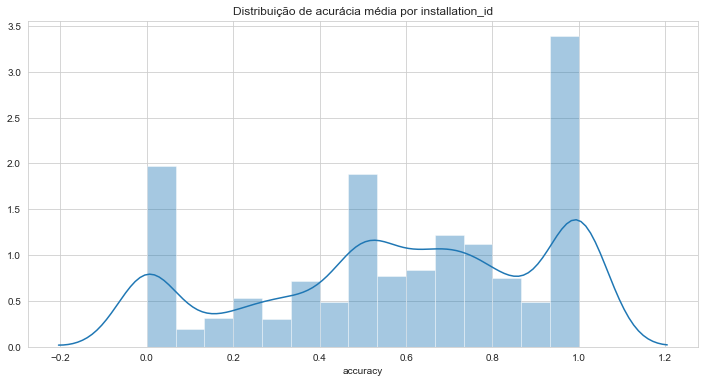

In [31]:
#Distribuição da acurácia média para cada installation_id.

data = labels.groupby('installation_id').mean()['accuracy']

fig, ax = plt.subplots(figsize = (12,6))
sns.distplot(data, ax = ax)
ax.set_title('Distribuição de acurácia média por installation_id')

(0, 50)

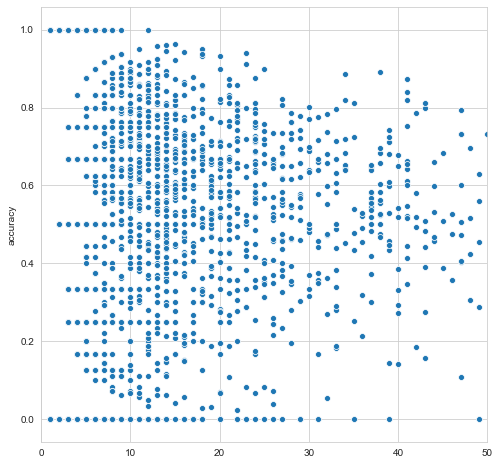

In [32]:
#O número de tentativas por installation_id x a acurácia média que ele possui
tries = list()
for id_ in data.index:
    id_data = labels.loc[labels.installation_id == id_]
    tries.append((id_data['num_correct'] + id_data['num_incorrect']).sum())

#tries

fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x=tries, y = data, ax = ax)
ax.set_xlim((0,50))

In [33]:
#Learning rate da criança
#Precisamos avaliar por mapa?

def get_session(group):
    return len(group.groupby('game_session').count())

num_session = labels.groupby('installation_id').apply(lambda x: get_session(x)).sort_values(ascending=False)
num_session[num_session > 15].tail(30)

installation_id
913fdbb9    17
9b6c5e60    17
6dd3f806    17
2b948865    17
856e7225    17
953b0187    17
2c2a886f    17
76684810    17
d82210f4    17
a6007735    17
051794c4    17
30ad064c    16
03401e19    16
60b6b084    16
9e6dbb51    16
f6ddbc4c    16
8c0c78bb    16
7f012464    16
90db3a9f    16
e6828a70    16
fc30ec02    16
e9bbbeed    16
54752410    16
f02a119d    16
52f9d617    16
95a90b82    16
885dff64    16
0a313708    16
b295dd4f    16
a46146c4    16
dtype: int64

In [34]:
#Vamos avaliar o installation_id a46146c4


## Feature Engineering
### Feature Extraction (Arquitetura)
Precisamos definir a melhor maneira de extrair as features do nosso modelo. A metodologia atual está ilustrada no fluxograma abaixo (Isso ainda está em desenvolvimento, mudanças são bem vindas!)

A arquitetura atual se parece com isso:
![](https://i.imgur.com/qTzetzO.png)

In [35]:
#Valkyrie

class Valkyrie:
    
    def __init__(self, train_data, test_data,assessment_data):
        self.full_data = train_data
        self.test_data = test_data
        self.assessment_data = assessment_data
        self.assessment_list = self.assessment_data.game_session.unique()
        print(
            
        '''------------------------------------------
            Dados carregados!
------------------------------------------
Os métodos disponíveis são:
        
    > .get_assessments():
    Retorna a relação entre cada sessão de treino e seu horário de início.
            
    > .extract_train():
    Retorna as features para os dados de treino.
            
    > .extract_test():
    Retorna as features para os dados de teste.
            
    > .extract_predicts():
    Retorna o ultimo assessment para cada installation_id nos dados de teste,
    basicamente ele retorna as game_sessions que precisamos prever.'''
)
    
    def _get_first_row(self, group):
        return group.iloc[0,:]
    
    def _get_last_row(self, group):
        return group.iloc[-1,7]
        
    
    def get_assessments(self):
        '''
        Essa função resgata para cada installation_id o horário de início de cada sessão de assessment realizada,
        retornando a installation_id, game_session e a hora realizada.
        '''
        assess_list = pd.DataFrame(columns=['installation_id', 'game_session', 'timestamp', 'title'])
        
        data = self.full_data.loc[self.full_data.game_session.isin(self.assessment_list), :]
        assess_list = pd.concat([assess_list, data.groupby('game_session').apply(lambda x: self._get_first_row(x))[['installation_id', 'game_session', 'timestamp', 'title']]])
        
        assess_list['timestamp'] = pd.to_datetime(assess_list.timestamp)
        return assess_list
    
    def extract_train(self):
        '''
        Esse método é o mais crítico, ele é o responsável por extrair a informação baseado no retorno do tempo do método
        get_assessments(), procuramos retornar features anteriores ao primeiro tempo registrado.
        '''
        print('Iniciando extração de treino...')
        
        assess_list = self.get_assessments()
        features = dict()
        result = pd.DataFrame()
        k = 0
        
        for install_id in assess_list.installation_id.unique():
            for row in assess_list.loc[assess_list.installation_id == install_id].iterrows():
                datetime = row[1]['timestamp']
                game_session = row[1]['game_session']
                title = row[1]['title']
                install_id = install_id
            
                data = self.full_data.loc[(self.full_data.installation_id == install_id) & (self.full_data.timestamp < datetime), :]
                features['installation_id'] = install_id
                features['game_session'] = game_session
                features['num_sessions'] = len(data.groupby('game_session').count()['event_id'])
                features['game_sessions'] = len(data.loc[data.type == 'Game'].groupby('game_session').count()['event_id'])
                features['clip_sessions'] = len(data.loc[data.type == 'Clip'].groupby('game_session').count()['event_id'])
                features['activity_sessions'] = len(data.loc[data.type == 'Activity'].groupby('game_session').count()['event_id'])
                features['assessments_sessions'] = len(data.loc[data.type == 'Assessment'].groupby('game_session').count()['event_id'])
                features['total_time'] = (data.timestamp.max() - data.timestamp.min()).total_seconds()
                features['time_played'] = data.groupby('game_session').apply(lambda x: self._get_last_row(x)).sum() / 1000
                features['num_tentativas'] = 0
                features['num_corretas'] = 0
                features['num_erradas'] = 0
                '''
                Essa sessão perfila o event_data para extrair informações de assessments
                '''
                assessment_data = data.loc[data.type == 'Assessment']
                event_data = assessment_data.loc[(assessment_data.event_code == 4100) | (assessment_data.event_code == 4110)]
                
                for event_row in event_data.iterrows():
                    if event_row[1]['title'] == 'Bird Measurer (Assessment)':
                        if event_row[1]['event_code'] == 4110:
                            if json.loads(event_row[1]['event_data'])['correct'] == True:
                                features['num_corretas'] += 1
                                features['num_tentativas'] += 1
                            else:
                                features['num_erradas'] += 1
                                features['num_tentativas'] += 1        
                        else:
                            continue
                    else:
                        if event_row[1]['event_code'] == 4100:
                            if json.loads(event_row[1]['event_data'])['correct'] == True:
                                features['num_corretas'] += 1
                                features['num_tentativas'] += 1
                            else:
                                features['num_erradas'] += 1
                                features['num_tentativas'] += 1
                
                           
                '''
                Contatenando os resultados obtidos
                '''
                result = pd.concat([result, pd.DataFrame(features, index = [0])], axis = 0, ignore_index = True)
                
            k += 1    
            print(f'{k} installation_id extraídos...')
        
        return result
            
    def extract_predicts(self):
        assess_data = self.test_data.loc[self.test_data.type == 'Assessment', :].sort_values('timestamp')
        return assess_data.groupby('installation_id').tail(1)
    
    def extract_test(self):
        unique_test_id = self.test_data.installation_id.unique()
        features = dict()
        result = pd.DataFrame()
        
        for test_id in unique_test_id:
            
            id_data = self.test_data.loc[self.test_data.installation_id == test_id, :]
            features['installation_id'] = test_id
            features['num_sessions'] = len(id_data.groupby('game_session').count()['event_id']) - 1
            features['game_sessions'] = len(id_data.loc[id_data.type == 'Game'].groupby('game_session').count()['event_id'])
            features['clip_sessions'] = len(id_data.loc[id_data.type == 'Clip'].groupby('game_session').count()['event_id'])
            features['activity_sessions'] = len(id_data.loc[id_data.type == 'Activity'].groupby('game_session').count()['event_id'])
            features['assessments_sessions'] = len(id_data.loc[id_data.type == 'Assessment'].groupby('game_session').count()['event_id']) - 1
            features['total_time'] = (id_data.timestamp.max() - id_data.timestamp.min()).total_seconds()
            features['time_played'] = id_data.groupby('game_session').apply(lambda x: self._get_last_row(x)).sum() / 1000
            features['num_tentativas'] = 0
            features['num_corretas'] = 0
            features['num_erradas'] = 0
            
            assessment_data = id_data.loc[id_data.type == 'Assessment']
            event_data = assessment_data.loc[(assessment_data.event_code == 4100) | (assessment_data.event_code == 4110)]
            
            for event_row in event_data.iterrows():
                if event_row[1]['title'] == 'Bird Measurer (Assessment)':
                    if event_row[1]['event_code'] == 4110:
                        if json.loads(event_row[1]['event_data'])['correct'] == True:
                            features['num_corretas'] += 1
                            features['num_tentativas'] += 1
                        else:
                            features['num_erradas'] += 1
                            features['num_tentativas'] += 1        
                    else:
                        continue
                else:
                    if event_row[1]['event_code'] == 4100:
                        if json.loads(event_row[1]['event_data'])['correct'] == True:
                            features['num_corretas'] += 1
                            features['num_tentativas'] += 1
                        else:
                            features['num_erradas'] += 1
                            features['num_tentativas'] += 1
            
            result = pd.concat([result, pd.DataFrame(features, index = [0])], axis = 0, ignore_index = True)
        
        return result
            
            


In [36]:
labels.loc[labels.installation_id == '01bdd720']

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
108,00097cda27afb726,01bdd720,Mushroom Sorter (Assessment),1,0,1.0,3
109,2cbd37f1442b2b80,01bdd720,Bird Measurer (Assessment),1,0,1.0,3
110,2d2412f750d8312a,01bdd720,Cart Balancer (Assessment),1,0,1.0,3
111,85941aefc2a33c8b,01bdd720,Cart Balancer (Assessment),1,0,1.0,3
112,bf5869a219895ae0,01bdd720,Chest Sorter (Assessment),0,4,0.0,0


In [37]:
teste = train.loc[(train.installation_id == '01bdd720') & (train.type == 'Assessment')]
teste = teste.loc[(teste.event_code == 4100) | (teste.event_code == 4110)]
teste

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
10937763,d122731b,2d2412f750d8312a,2019-09-15 00:29:36.016000+00:00,"{""correct"":true,""left"":[{""id"":""gem05"",""weight""...",01bdd720,30.0,4100.0,26641.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
10938255,93b353f2,bf5869a219895ae0,2019-09-15 00:46:56.539000+00:00,"{""correct"":false,""pillars"":[],""event_count"":38...",01bdd720,38.0,4100.0,38684.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
10938264,93b353f2,bf5869a219895ae0,2019-09-15 00:47:04.036000+00:00,"{""correct"":false,""pillars"":[],""event_count"":47...",01bdd720,47.0,4100.0,46184.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
10938270,93b353f2,bf5869a219895ae0,2019-09-15 00:47:08.381000+00:00,"{""correct"":false,""pillars"":[],""event_count"":53...",01bdd720,53.0,4100.0,50534.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
10938316,93b353f2,bf5869a219895ae0,2019-09-15 00:48:02.289000+00:00,"{""correct"":false,""pillars"":[],""event_count"":94...",01bdd720,94.0,4100.0,104437.0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
10942224,25fa8af4,00097cda27afb726,2019-09-15 16:37:00.433000+00:00,"{""correct"":true,""stumps"":[1,2,5],""event_count""...",01bdd720,31.0,4100.0,19010.0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
10942656,17113b36,2cbd37f1442b2b80,2019-09-15 17:01:14.299000+00:00,"{""correct"":true,""caterpillars"":[4,8,5],""event_...",01bdd720,38.0,4110.0,64661.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
10942678,070a5291,2cbd37f1442b2b80,2019-09-15 17:01:46.667000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":6...",01bdd720,60.0,4100.0,97029.0,Bird Measurer (Assessment),Assessment,TREETOPCITY
10943092,d122731b,85941aefc2a33c8b,2019-09-15 17:16:38.601000+00:00,"{""correct"":true,""left"":[{""id"":""gem05"",""weight""...",01bdd720,26.0,4100.0,20029.0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES


In [38]:
valk = Valkyrie(train_data=train, test_data=test, assessment_data=assessments)
#train_features = valk.extract_train()
#train_features.to_csv('train_features.csv')
train_features = pd.read_csv('train_features.csv').drop('Unnamed: 0', axis = 1)
train_features.head()

------------------------------------------
            Dados carregados!
------------------------------------------
Os métodos disponíveis são:
        
    > .get_assessments():
    Retorna a relação entre cada sessão de treino e seu horário de início.
            
    > .extract_train():
    Retorna as features para os dados de treino.
            
    > .extract_test():
    Retorna as features para os dados de teste.
            
    > .extract_predicts():
    Retorna o ultimo assessment para cada installation_id nos dados de teste,
    basicamente ele retorna as game_sessions que precisamos prever.


,installation_id,game_session,num_sessions,game_sessions,clip_sessions,activity_sessions,assessments_sessions,total_time,time_played,num_tentativas,num_corretas,num_erradas
0,01bdd720,00097cda27afb726,39,7,24,6,2,59160.397,2756.198,5,1,4
1,01bdd720,2cbd37f1442b2b80,46,9,27,7,3,60645.129,3322.953,6,2,4
2,01bdd720,2d2412f750d8312a,14,2,11,1,0,1112.574,482.468,0,0,0
3,01bdd720,85941aefc2a33c8b,53,11,30,8,4,61610.218,3981.080,7,3,4
4,01bdd720,bf5869a219895ae0,20,4,13,2,1,2213.938,1314.164,1,1,0


In [39]:
test_features = valk.extract_test()
test_features.head(10)

,installation_id,num_sessions,game_sessions,clip_sessions,activity_sessions,assessments_sessions,total_time,time_played,num_tentativas,num_corretas,num_erradas
0,00abaee7,25,3,14,7,1,162107.283,2723.866,1,1,0
1,01242218,57,12,29,11,5,1466675.131,3281.050,11,4,7
2,017c5718,8,0,6,2,0,4277058.612,112.850,0,0,0
3,01a44906,13,1,10,2,0,208565.000,188.268,0,0,0
4,01bc6cb6,24,6,17,1,0,1911368.507,1206.578,0,0,0
5,02256298,13,2,6,4,1,1931168.846,1324.841,1,1,0
6,0267757a,20,5,13,2,0,1565449.671,1836.034,0,0,0
7,027e7ce5,42,7,17,9,9,1571798.624,2029.407,9,7,2
8,02a29f99,21,5,10,3,3,609438.841,1473.392,15,1,14
9,0300c576,16,1,15,0,0,975.237,14.212,0,0,0


In [40]:
to_predict = valk.extract_predicts()
print(to_predict.shape)
to_predict.head()

(1000, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
903369,3bfd1a65,b3c584bce0e960aa,2019-07-24 14:32:04.621000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",c798859f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
184960,5b49460a,a07ae77cf151dcfe,2019-07-24 16:04:10.637000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",2ab22ff2,1,2000,0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
285506,5b49460a,9e69cfd404fd75d3,2019-07-24 16:27:26.934000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",4124318e,1,2000,0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
657620,3bfd1a65,51b56dfe1cc0fb90,2019-07-24 21:35:00.171000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",8eeba692,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
525227,3bfd1a65,0376e5987361e0d1,2019-07-25 01:24:24.391000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",7a31ed2b,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [41]:
#Juntando os labels as features de treino

train_data = train_features.merge(labels[['game_session','title', 'accuracy', 'accuracy_group']], how = 'left', on = 'game_session')
train_data = train_data.fillna(0) #Pessoas que tem a primeira atividade registrada como assessment possuem time_played como NaN
train_data.isnull().sum()

installation_id         0
game_session            0
num_sessions            0
game_sessions           0
clip_sessions           0
activity_sessions       0
assessments_sessions    0
total_time              0
time_played             0
num_tentativas          0
num_corretas            0
num_erradas             0
title                   0
accuracy                0
accuracy_group          0
dtype: int64

In [42]:
#Unindo as features de teste as linhas que precisam ser preditas.

test_data = to_predict.merge(test_features, how = 'left', on = 'installation_id')
test_data.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,...,num_sessions,game_sessions,clip_sessions,activity_sessions,assessments_sessions,total_time,time_played,num_tentativas,num_corretas,num_erradas
0,3bfd1a65,b3c584bce0e960aa,2019-07-24 14:32:04.621000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",c798859f,1,2000,0,Mushroom Sorter (Assessment),Assessment,...,10,1,9,0,0,2220.371,300.532,0,0,0
1,5b49460a,a07ae77cf151dcfe,2019-07-24 16:04:10.637000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",2ab22ff2,1,2000,0,Chest Sorter (Assessment),Assessment,...,10,0,8,2,0,57585.276,1672.707,0,0,0
2,5b49460a,9e69cfd404fd75d3,2019-07-24 16:27:26.934000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",4124318e,1,2000,0,Chest Sorter (Assessment),Assessment,...,65,15,30,11,9,5147.618,1972.098,18,6,12
3,3bfd1a65,51b56dfe1cc0fb90,2019-07-24 21:35:00.171000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",8eeba692,1,2000,0,Mushroom Sorter (Assessment),Assessment,...,12,4,5,1,2,2101.484,1146.287,2,2,0
4,3bfd1a65,0376e5987361e0d1,2019-07-25 01:24:24.391000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",7a31ed2b,1,2000,0,Mushroom Sorter (Assessment),Assessment,...,3,0,2,1,0,155.089,42.345,0,0,0


In [43]:
#Conferindo os dados de teste
test_features.isnull().sum()

installation_id         0
num_sessions            0
game_sessions           0
clip_sessions           0
activity_sessions       0
assessments_sessions    0
total_time              0
time_played             0
num_tentativas          0
num_corretas            0
num_erradas             0
dtype: int64

In [44]:
to_predict.isnull().sum()

event_id           0
game_session       0
timestamp          0
event_data         0
installation_id    0
event_count        0
event_code         0
game_time          0
title              0
type               0
world              0
dtype: int64

## Modelagem

In [45]:
train_data.head()

,installation_id,game_session,num_sessions,game_sessions,clip_sessions,activity_sessions,assessments_sessions,total_time,time_played,num_tentativas,num_corretas,num_erradas,title,accuracy,accuracy_group
0,01bdd720,00097cda27afb726,39,7,24,6,2,59160.397,2756.198,5,1,4,Mushroom Sorter (Assessment),1.0,3
1,01bdd720,2cbd37f1442b2b80,46,9,27,7,3,60645.129,3322.953,6,2,4,Bird Measurer (Assessment),1.0,3
2,01bdd720,2d2412f750d8312a,14,2,11,1,0,1112.574,482.468,0,0,0,Cart Balancer (Assessment),1.0,3
3,01bdd720,85941aefc2a33c8b,53,11,30,8,4,61610.218,3981.080,7,3,4,Cart Balancer (Assessment),1.0,3
4,01bdd720,bf5869a219895ae0,20,4,13,2,1,2213.938,1314.164,1,1,0,Chest Sorter (Assessment),0.0,0


In [46]:
test_data.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,...,num_sessions,game_sessions,clip_sessions,activity_sessions,assessments_sessions,total_time,time_played,num_tentativas,num_corretas,num_erradas
0,3bfd1a65,b3c584bce0e960aa,2019-07-24 14:32:04.621000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",c798859f,1,2000,0,Mushroom Sorter (Assessment),Assessment,...,10,1,9,0,0,2220.371,300.532,0,0,0
1,5b49460a,a07ae77cf151dcfe,2019-07-24 16:04:10.637000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",2ab22ff2,1,2000,0,Chest Sorter (Assessment),Assessment,...,10,0,8,2,0,57585.276,1672.707,0,0,0
2,5b49460a,9e69cfd404fd75d3,2019-07-24 16:27:26.934000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",4124318e,1,2000,0,Chest Sorter (Assessment),Assessment,...,65,15,30,11,9,5147.618,1972.098,18,6,12
3,3bfd1a65,51b56dfe1cc0fb90,2019-07-24 21:35:00.171000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",8eeba692,1,2000,0,Mushroom Sorter (Assessment),Assessment,...,12,4,5,1,2,2101.484,1146.287,2,2,0
4,3bfd1a65,0376e5987361e0d1,2019-07-25 01:24:24.391000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",7a31ed2b,1,2000,0,Mushroom Sorter (Assessment),Assessment,...,3,0,2,1,0,155.089,42.345,0,0,0


In [47]:
features = ['title', 'num_sessions', 'game_sessions', 'clip_sessions', 'activity_sessions', 'assessments_sessions', 'total_time', 'time_played', 'num_tentativas',
           'num_corretas', 'num_erradas']

x = train_data[features]
y = train_data['accuracy_group']

In [48]:
x = pd.get_dummies(x, columns=['title'])
x.head()

,num_sessions,game_sessions,clip_sessions,activity_sessions,assessments_sessions,total_time,time_played,num_tentativas,num_corretas,num_erradas,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Cauldron Filler (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
0,39,7,24,6,2,59160.397,2756.198,5,1,4,0,0,0,0,1
1,46,9,27,7,3,60645.129,3322.953,6,2,4,1,0,0,0,0
2,14,2,11,1,0,1112.574,482.468,0,0,0,0,1,0,0,0
3,53,11,30,8,4,61610.218,3981.080,7,3,4,0,1,0,0,0
4,20,4,13,2,1,2213.938,1314.164,1,1,0,0,0,0,1,0


In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.8, stratify = y)

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = Pipeline([('rf', RandomForestClassifier(n_estimators = 500, max_depth=8))])
svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])


clf.fit(x, y)

Pipeline(memory=None,
         steps=[('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [62]:
svc.score(x_test, y_test)

0.5986433013001696

In [60]:
clf.score(x_test, y_test)

0.6057094403617863

In [73]:
#Submit zone

x_submit = test_data[features]
x_submit = pd.get_dummies(x_submit, columns=['title'])
x_submit.head()

#submit
submit = pd.DataFrame({'installation_id': test_data.installation_id})

In [88]:
sample.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [90]:
to_kaggle.head(10)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
5,02256298,3
6,0267757a,3
7,027e7ce5,3
8,02a29f99,0
9,0300c576,3


In [75]:
submit['predict'] = clf.predict(x_submit)


In [86]:
to_kaggle = sample.merge(submit, how = 'left', on = 'installation_id').drop('accuracy_group', axis = 1).rename(columns = {'predict': 'accuracy_group'})
to_kaggle.to_csv('submit.csv', index = False)

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=8)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
rf.score(x_test, y_test)

0.6091011871113623

## Validação

# KAPPA Steps

## 1st
- Create a multi class confusion matrix "O" between predicted and actual ratings.

## 2nd
- Construct a weight matrix "W" which calculates the weight between the actual and predicted ratings.

## 3rd
- Calculate value_counts() for each rating in preds and actuals.

## 4th
- Calculate "E", which is the outer product of two value_count vectors.

## 5th
- Normalise the "E" and "O" matrix.

## 6th
- Calculate "Weighted KAPPA" as per formula
- code: quadratic_kappa(actuals, preds)

## Interpretation of "Weighted KAPPA"

- A weighted Kappa is a metric which is used to calculate the amount of similarity between predictions and actuals. A perfect score of 1.0 is granted when both the predictions and actuals are the same. Whereas, the least possible score is -1 which is given when the predictions are furthest away from actuals. In our case, consider all actuals were 0's and all predictions were 3's. This would lead to a QWKP score of -1. The aim is to get as close to 1 as possible. Generally a score of 0.6+ is considered to be a really good score.